In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# LOAD DATA

bank_accounts = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\bank_accounts.parquet")
credit_cards = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\credit_cards.parquet")
devices = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\devices.parquet")
transactions = pd.read_parquet(r"C:\Pytorch\Fraud Detection\data\transactions.parquet")

bank_accounts.shape, credit_cards.shape, devices.shape, transactions.shape

((350841, 2), (38708, 2), (1430311, 2), (620947, 4))

In [3]:
print('Bank Accounts : ', bank_accounts.shape)
display(bank_accounts.head(5))
print('\nCredit Cards : ', credit_cards.shape)
display(credit_cards.head(5))
print('\nDevices : ', devices.shape)
display(devices.head(5))
print('\nTransactions : ', transactions.shape)
display(transactions.head(5))

Bank Accounts :  (350841, 2)


,user_id,bank_account
0,C419128,0
1,C19901940,0
2,C21407120,0
3,C54966514,0
4,C80507942,0000039209



Credit Cards :  (38708, 2)


,user_id,credit_card
0,C63177098,30024x08-2020
1,C18468478,30024x08-2021
2,C22163518,30024x12-2020
3,C5845542,30134x02-2021
4,C31447074,30134x10-2017



Devices :  (1430311, 2)


,user_id,device
0,C10146534,+++3s/8YvFLP/ePRr1RQw27UpSq8iJAdybTVjPiHUc8=
1,C123913948,+++GW0vx4xLjxTNHKWO+kWDS+w45sJZz//ZUlST6TCg=
2,C147271198,+++b/gSDahdOss9vZHx/0qorN1zrvnT0DJ6vttl/YBE=
3,C16126238,+++hbM5PFzSOZglwP8ORRbmr40UrvzEgCMq6ZtuJjMu=
4,C102164030,+++ivFTF+M/DxnA21MRSxuqZO/KUheIu0RXva/O41sq=



Transactions :  (620947, 4)


,transid,org_user_id,dest_user_id,amount
0,1953278092,C47388162,C20822974,99094
1,1953295120,C26855196,C16416890,52714
2,1953306402,C121296714,C28477978,43888
3,1953314712,C131221930,C72837912,45771
4,1953381964,C183398314,C28423332,96840


In [4]:
# DROP DUPLICATE DATA

bank_accounts = bank_accounts.drop_duplicates()
credit_cards = credit_cards.drop_duplicates()
devices = devices.drop_duplicates()
transactions = transactions.drop_duplicates()

bank_accounts.shape, credit_cards.shape, devices.shape, transactions.shape

((350572, 2), (38015, 2), (1430311, 2), (620947, 4))

In [5]:
# FEATURE ENGINEERING

# ADD FEATURE HOW MANY BANK ACCOUNT EACH USER HAVE
number_bank_accounts = bank_accounts.groupby('user_id')['bank_account'].count().reset_index(name = 'number_of_bank_acc_owned_each_user')
bank_accounts = pd.merge(left = bank_accounts, right = number_bank_accounts, on = 'user_id', how = 'outer')

# ADD FEATURE HOW MANY CREDIT CARD EACH USER HAVE
number_credit_card = credit_cards.groupby('user_id')['credit_card'].count().reset_index(name = 'number_of_credit_card_owned_each_user')
credit_cards = pd.merge(left = credit_cards, right = number_credit_card, on = 'user_id', how = 'outer')

# ADD FEATURE HOW MUCH DEVICES USER HAVE
number_devices = devices.groupby('user_id')['device'].nunique().reset_index(name = 'number_of_devices_owned_each_user')  # CREATE NEW COL
devices = devices.drop(columns = 'device') # --> DROP USELESS
devices = pd.merge(left = devices, right = number_devices, on = 'user_id', how = 'outer')


# FIRST, RENAME TRANSACTION COLUMNS
transactions = transactions.rename(columns = {'org_user_id' : 'sender_id', 'dest_user_id' : 'receiver_id'})

# IDENTIFY SENDER AND RECEIVER FROM TRANSACTION DATASET
sender_summary = transactions.groupby('sender_id')['amount'].agg(['count', 'sum', 'mean']).reset_index().rename(columns = {'sender_id' : 'user_id', 
                                                                                                                         'count' : 'number_of_transfer', 
                                                                                                                         'sum' : 'sum_transfer', 
                                                                                                                         'mean' : 'mean_transfer'})

receiver_summary = transactions.groupby('receiver_id')['amount'].agg(['count', 'sum', 'mean']).reset_index().rename(columns = {'receiver_id' : 'user_id',
                                                                                                                               'count' : 'number_of_received',
                                                                                                                               'sum' : 'sum_received',
                                                                                                                               'mean' : 'mean_received'})


# MERGE SENT AND RECEIVER
transactions = pd.merge(left = sender_summary, right = receiver_summary, how = 'outer', on = 'user_id')

# MERGE BANK ACOUNT, CREDIT CARDS AND DEVICES
user_profile = pd.merge(left = bank_accounts, right = credit_cards, how = 'outer', on = 'user_id').merge(right = devices, on = 'user_id', how = 'outer')

# MERGE THEM WITH TRANSACTIONS DATASET
user_profile = pd.merge(left = user_profile, right = transactions, on = 'user_id', how = 'outer')

# DROP DUPLICATES
user_profile = user_profile.drop_duplicates()

# ANALYSIS MISSING VALUES VS TRANSACTION ACTIVITIES
user_profile['n_missing'] = user_profile.isna().sum(axis = 1)
user_profile['number_of_transaction'] = user_profile[['number_of_transfer', 'number_of_received']].sum(axis = 1, skipna = True)
user_profile['total_transaction'] = user_profile[['sum_transfer', 'sum_received']].sum(axis = 1, skipna = True)

user_profile

,user_id,bank_account,number_of_bank_acc_owned_each_user,credit_card,number_of_credit_card_owned_each_user,number_of_devices_owned_each_user,number_of_transfer,sum_transfer,mean_transfer,number_of_received,sum_received,mean_received,n_missing,number_of_transaction,total_transaction
0,C100000188,NaN,NaN,NaN,NaN,2.0,1.0,44574.0,44574.0,NaN,NaN,NaN,7,1.0,44574.0
2,C10000108,4042994223,1.0,NaN,NaN,3.0,1.0,20156.0,20156.0,NaN,NaN,NaN,5,1.0,20156.0
5,C10000114,2222212388,1.0,83933x09-2020,1.0,14.0,NaN,NaN,NaN,340.0,19014251.0,55924.267647,3,340.0,19014251.0
19,C100001610,0294322322,1.0,NaN,NaN,2.0,1.0,54207.0,54207.0,NaN,NaN,NaN,5,1.0,54207.0
21,C100001712,2990003333421,3.0,NaN,NaN,6.0,5.0,139464.0,27892.8,NaN,NaN,NaN,5,5.0,139464.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061321,C99995312,NaN,NaN,NaN,NaN,2.0,1.0,60253.0,60253.0,NaN,NaN,NaN,7,1.0,60253.0
2061323,C99997576,2012380222,1.0,33238x06-2019,1.0,1.0,NaN,NaN,NaN,2.0,66303.0,33151.500000,3,2.0,66303.0
2061324,C99998872,311202098483829,1.0,NaN,NaN,2.0,1.0,63551.0,63551.0,NaN,NaN,NaN,5,1.0,63551.0
2061326,C99999032,NaN,NaN,NaN,NaN,4.0,2.0,67297.0,33648.5,NaN,NaN,NaN,7,2.0,67297.0


In [6]:
# SPLIT DATA

FEATURES = ['number_of_bank_acc_owned_each_user', 'number_of_credit_card_owned_each_user', 'number_of_devices_owned_each_user', 'number_of_transfer', 'number_of_received',
            'sum_transfer', 'sum_received', 'number_of_transaction', 'total_transaction', 'n_missing']

x = user_profile.copy()
# FILL NULL VALUE WITH 0 BECAUSE ISOLATION FOREST DOESNT ACCEPT MISSING VALUES
x = x.fillna(0)

# DROP DUPLICATE VALUE
x_train = x[FEATURES + ['user_id']].drop_duplicates()

# SET user_id AS AN INDEX
x_train = x_train.set_index('user_id')[FEATURES]

x_train

,number_of_bank_acc_owned_each_user,number_of_credit_card_owned_each_user,number_of_devices_owned_each_user,number_of_transfer,number_of_received,sum_transfer,sum_received,number_of_transaction,total_transaction,n_missing
user_id,,,,,,,,,,
C100000188,0.0,0.0,2.0,1.0,0.0,44574.0,0.0,1.0,44574.0,7
C10000108,1.0,0.0,3.0,1.0,0.0,20156.0,0.0,1.0,20156.0,5
C10000114,1.0,1.0,14.0,0.0,340.0,0.0,19014251.0,340.0,19014251.0,3
C100001610,1.0,0.0,2.0,1.0,0.0,54207.0,0.0,1.0,54207.0,5
C100001712,3.0,0.0,6.0,5.0,0.0,139464.0,0.0,5.0,139464.0,5
...,...,...,...,...,...,...,...,...,...,...
C99995312,0.0,0.0,2.0,1.0,0.0,60253.0,0.0,1.0,60253.0,7
C99997576,1.0,1.0,1.0,0.0,2.0,0.0,66303.0,2.0,66303.0,3
C99998872,1.0,0.0,2.0,1.0,0.0,63551.0,0.0,1.0,63551.0,5


In [11]:
# TRAIN LOCAL OUTLIER FACTOR

lof = LocalOutlierFactor(n_neighbors = 20, contamination = 0.01)
x_train['lof_predict'] = lof.fit_predict(x_train)
x_train['lof_score']   = lof.negative_outlier_factor_

# MERGE LOF SCORE AND PREDICT WITH USER PROFILE DATA
user_profile = pd.merge(left = user_profile, right = x_train[['lof_predict', 'lof_score']], left_on = 'user_id', right_index = True, how = 'left')

user_profile

,user_id,bank_account,number_of_bank_acc_owned_each_user,credit_card,number_of_credit_card_owned_each_user,number_of_devices_owned_each_user,number_of_transfer,sum_transfer,mean_transfer,number_of_received,sum_received,mean_received,n_missing,number_of_transaction,total_transaction,lof_predict,lof_score
0,C100000188,NaN,NaN,NaN,NaN,2.0,1.0,44574.0,44574.0,NaN,NaN,NaN,7,1.0,44574.0,1,-1.007613
2,C10000108,4042994223,1.0,NaN,NaN,3.0,1.0,20156.0,20156.0,NaN,NaN,NaN,5,1.0,20156.0,1,-1.013163
5,C10000114,2222212388,1.0,83933x09-2020,1.0,14.0,NaN,NaN,NaN,340.0,19014251.0,55924.267647,3,340.0,19014251.0,1,-0.981221
19,C100001610,0294322322,1.0,NaN,NaN,2.0,1.0,54207.0,54207.0,NaN,NaN,NaN,5,1.0,54207.0,1,-0.984618
21,C100001712,2990003333421,3.0,NaN,NaN,6.0,5.0,139464.0,27892.8,NaN,NaN,NaN,5,5.0,139464.0,1,-0.972498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061321,C99995312,NaN,NaN,NaN,NaN,2.0,1.0,60253.0,60253.0,NaN,NaN,NaN,7,1.0,60253.0,1,-1.011582
2061323,C99997576,2012380222,1.0,33238x06-2019,1.0,1.0,NaN,NaN,NaN,2.0,66303.0,33151.500000,3,2.0,66303.0,1,-0.974418
2061324,C99998872,311202098483829,1.0,NaN,NaN,2.0,1.0,63551.0,63551.0,NaN,NaN,NaN,5,1.0,63551.0,1,-1.014097
2061326,C99999032,NaN,NaN,NaN,NaN,4.0,2.0,67297.0,33648.5,NaN,NaN,NaN,7,2.0,67297.0,1,-1.000033


In [13]:
# DISPLAY ANOMALY USER

user_anomaly = user_profile[user_profile['lof_score'] < 0].sort_values(by = ['lof_score'], ascending = True)  #--> GET THE MOST ANOMALY
user_anomaly = user_anomaly.drop_duplicates(subset = 'user_id')   # --> ONLY SELECT 1 USER_ID PER ANOMALY

user_anomaly

,user_id,bank_account,number_of_bank_acc_owned_each_user,credit_card,number_of_credit_card_owned_each_user,number_of_devices_owned_each_user,number_of_transfer,sum_transfer,mean_transfer,number_of_received,sum_received,mean_received,n_missing,number_of_transaction,total_transaction,lof_predict,lof_score
1317253,C39934986,9922039299,1.0,NaN,NaN,4.0,1.0,15183.0,15183.000000,1.0,10653.0,10653.000000,2,2.0,25836.0,-1,-464.469561
49478,C104925338,810002021082820,2.0,NaN,NaN,4.0,2.0,152886.0,76443.000000,1.0,10780.0,10780.000000,2,3.0,163666.0,-1,-343.965828
1456662,C48154890,423402002929809,2.0,NaN,NaN,5.0,2.0,152233.0,76116.500000,1.0,12564.0,12564.000000,2,3.0,164797.0,-1,-308.050338
1569783,C5673854,2990008430499,2.0,83229x06-2018,2.0,6.0,4.0,177792.0,44448.000000,1.0,11434.0,11434.000000,0,5.0,189226.0,-1,-303.908791
1890721,C8228536,9202041802809,2.0,NaN,NaN,6.0,3.0,168961.0,56320.333333,1.0,14278.0,14278.000000,2,4.0,183239.0,-1,-272.830986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368422,C42718154,2090183392,4.0,NaN,NaN,4.0,NaN,NaN,NaN,2.0,112942.0,56471.000000,5,2.0,112942.0,1,-0.915297
44796,C104477042,330833988,4.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,112941.0,56470.500000,5,2.0,112941.0,1,-0.914476
421293,C148839536,22902320009449,2.0,NaN,NaN,3.0,NaN,NaN,NaN,3.0,112940.0,37646.666667,5,3.0,112940.0,1,-0.913690
164924,C116915282,9910804949,1.0,NaN,NaN,11.0,NaN,NaN,NaN,3.0,112940.0,37646.666667,5,3.0,112940.0,1,-0.913579


In [14]:
# DISPLAY 10 MOST ANOMALY USER

user_anomaly[:10]

,user_id,bank_account,number_of_bank_acc_owned_each_user,credit_card,number_of_credit_card_owned_each_user,number_of_devices_owned_each_user,number_of_transfer,sum_transfer,mean_transfer,number_of_received,sum_received,mean_received,n_missing,number_of_transaction,total_transaction,lof_predict,lof_score
1317253,C39934986,9922039299,1.0,NaN,NaN,4.0,1.0,15183.0,15183.000000,1.0,10653.0,10653.0,2,2.0,25836.0,-1,-464.469561
49478,C104925338,810002021082820,2.0,NaN,NaN,4.0,2.0,152886.0,76443.000000,1.0,10780.0,10780.0,2,3.0,163666.0,-1,-343.965828
1456662,C48154890,423402002929809,2.0,NaN,NaN,5.0,2.0,152233.0,76116.500000,1.0,12564.0,12564.0,2,3.0,164797.0,-1,-308.050338
1569783,C5673854,2990008430499,2.0,83229x06-2018,2.0,6.0,4.0,177792.0,44448.000000,1.0,11434.0,11434.0,0,5.0,189226.0,-1,-303.908791
1890721,C8228536,9202041802809,2.0,NaN,NaN,6.0,3.0,168961.0,56320.333333,1.0,14278.0,14278.0,2,4.0,183239.0,-1,-272.830986
236940,C125110626,1000022823338,1.0,NaN,NaN,2.0,2.0,167511.0,83755.500000,1.0,15234.0,15234.0,2,3.0,182745.0,-1,-270.737833
1205445,C34309530,9342240238,1.0,NaN,NaN,2.0,5.0,201161.0,40232.200000,1.0,15983.0,15983.0,2,6.0,217144.0,-1,-268.387061
1280861,C38058216,249002002482823,2.0,NaN,NaN,2.0,2.0,169703.0,84851.500000,1.0,11457.0,11457.0,2,3.0,181160.0,-1,-251.287660
312200,C134228764,2440003044093,1.0,NaN,NaN,4.0,3.0,205417.0,68472.333333,1.0,17582.0,17582.0,2,4.0,222999.0,-1,-243.667818
612271,C17676264,2390022482213,1.0,NaN,NaN,4.0,2.0,124229.0,62114.500000,1.0,10627.0,10627.0,2,3.0,134856.0,-1,-166.542182


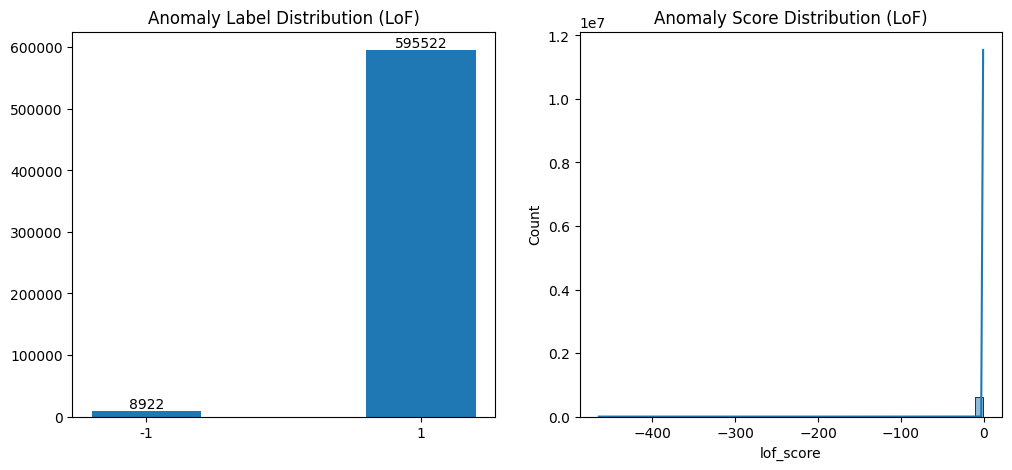

In [15]:
# CHECK DISTRIBUTION OF ANOMALY

plt.figure(figsize = (12, 5))

# GROUPBY ANOMALY LABEL
plt.subplot(1, 2, 1)
anomaly_label = user_profile.groupby(by = 'lof_predict')['lof_score'].count()
bars = plt.bar(x = anomaly_label.index, height = anomaly_label.values)   

plt.xticks(anomaly_label.index, anomaly_label.index)  # --> X AXIS CONTAIN TRUE LABEL, NOT INTERVAL

# GET LABEL TEXT EACH BAR
for bar in bars:
    plt.text(x = bar.get_x() + bar.get_width() / 2, 
             y = bar.get_height(),
             s = str(bar.get_height()),
             ha = 'center', 
             va = 'bottom')
plt.title('Anomaly Label Distribution (LoF)')

plt.subplot(1, 2, 2)
sns.histplot(user_profile['lof_score'], kde = True, bins = 50)
plt.title('Anomaly Score Distribution (LoF)')

plt.show()

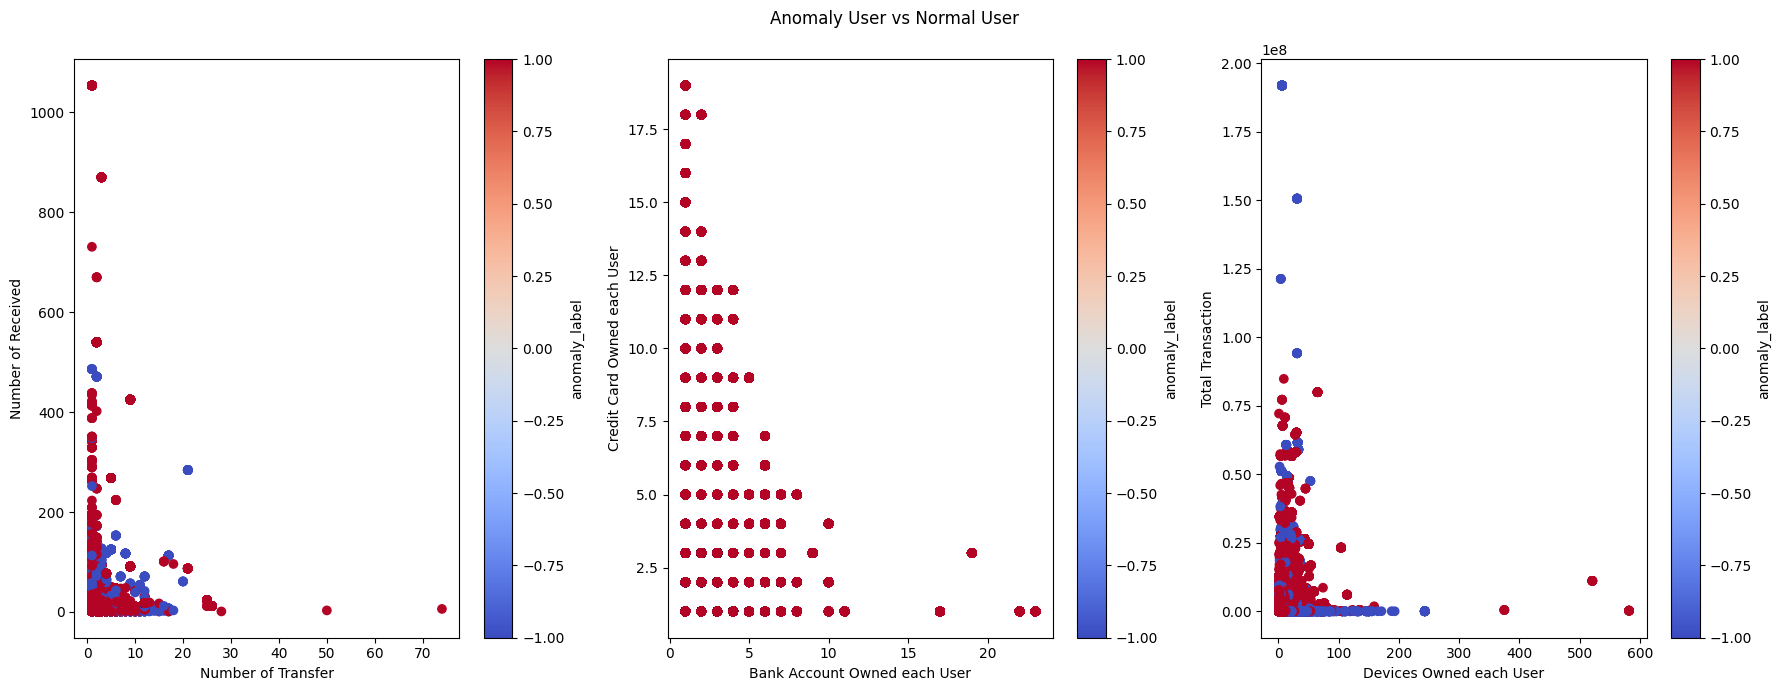

In [27]:
# ANOMALY VS NORMAL USER 

plt.figure(figsize = (18, 7))

# NUMBER OF TRANSFER VS NUMBER OF RECEIVED USER ANOMALY
plt.subplot(1, 3, 1)
plt.scatter(x = user_profile['number_of_transfer'], y = user_profile['number_of_received'], c = user_profile['lof_predict'], cmap = 'coolwarm')
plt.colorbar(label = 'anomaly_label')
plt.xlabel('Number of Transfer')
plt.ylabel('Number of Received')

plt.subplot(1, 3, 2)
plt.scatter(x = user_profile['number_of_bank_acc_owned_each_user'], y = user_profile['number_of_credit_card_owned_each_user'], c = user_profile['lof_predict'], cmap = 'coolwarm')
plt.colorbar(label = 'anomaly_label')
plt.xlabel('Bank Account Owned each User')
plt.ylabel('Credit Card Owned each User')

plt.subplot(1, 3, 3)
plt.scatter(x = user_profile['number_of_devices_owned_each_user'], y = user_profile['total_transaction'], c = user_profile['lof_predict'], cmap = 'coolwarm')
plt.colorbar(label = 'anomaly_label')
plt.xlabel('Devices Owned each User')
plt.ylabel('Total Transaction')

plt.suptitle('Anomaly User vs Normal User')
plt.tight_layout()
plt.show()

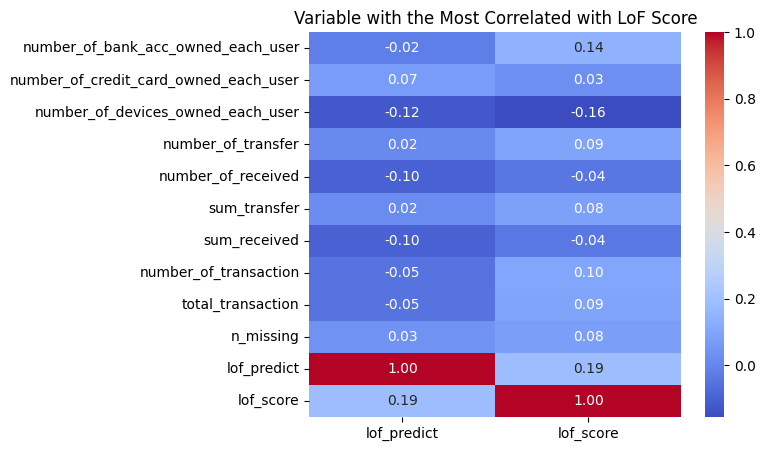

In [35]:
# CHECK CORRELATION BETWEEN ANOMALY SCORE WITH USER PROFILE FEATURES

plt.figure(figsize = (6, 5))
anomaly_corr = user_profile[FEATURES + ['lof_predict', 'lof_score']].corr(method = 'spearman')

sns.heatmap(data = anomaly_corr[['lof_predict', 'lof_score']], cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Variable with the Most Correlated with LoF Score')
plt.show()

In [28]:
# STATISTIK ANOMALY USER VS NORMAL USER

print('Statistic Normal User : ')
normal_stats = user_profile[user_profile['lof_predict'] == 1].describe()
display(normal_stats)

print('\nStatistic Anomaly User : ')
anomaly_stats = user_profile[user_profile['lof_predict'] == -1].describe()
display(anomaly_stats)

Statistic Normal User : 


,number_of_bank_acc_owned_each_user,number_of_credit_card_owned_each_user,number_of_devices_owned_each_user,number_of_transfer,sum_transfer,mean_transfer,number_of_received,sum_received,mean_received,n_missing,number_of_transaction,total_transaction,lof_predict,lof_score
count,851514.000000,294258.000000,1.088313e+06,718338.000000,7.183380e+05,718338.000000,427076.000000,4.270760e+05,427076.000000,1.094385e+06,1.094385e+06,1.094385e+06,1094385.0,1.094385e+06
mean,3.197162,4.612993,4.554666e+00,1.560707,8.564350e+04,54826.688423,22.165352,1.212314e+06,55197.407620,4.771754e+00,9.674297e+00,5.293122e+05,1.0,-1.049897e+00
std,4.007014,3.264378,5.550415e+00,1.444920,8.582763e+04,23634.169476,80.814884,4.413268e+06,18260.781038,1.581190e+00,5.154628e+01,2.815312e+06,0.0,1.302419e-01
min,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+04,10000.000000,1.000000,1.000200e+04,10002.000000,0.000000e+00,1.000000e+00,1.000000e+04,1.0,-2.104681e+00
25%,1.000000,2.000000,2.000000e+00,1.000000,4.066200e+04,36224.083333,1.000000,6.918975e+04,45591.000000,3.000000e+00,1.000000e+00,4.851500e+04,1.0,-1.049797e+00
50%,2.000000,4.000000,3.000000e+00,1.000000,6.848500e+04,54897.250000,3.000000,1.463680e+05,54797.960000,5.000000e+00,1.000000e+00,8.287000e+04,1.0,-1.004694e+00
75%,3.000000,6.000000,6.000000e+00,2.000000,9.563800e+04,72945.000000,9.000000,4.711400e+05,65408.285714,5.000000e+00,3.000000e+00,1.595980e+05,1.0,-9.898049e-01
max,39.000000,19.000000,5.820000e+02,74.000000,3.843689e+06,99999.000000,1535.000000,8.484292e+07,99999.000000,8.000000e+00,1.535000e+03,8.484292e+07,1.0,-8.723410e-01



Statistic Anomaly User : 


,number_of_bank_acc_owned_each_user,number_of_credit_card_owned_each_user,number_of_devices_owned_each_user,number_of_transfer,sum_transfer,mean_transfer,number_of_received,sum_received,mean_received,n_missing,number_of_transaction,total_transaction,lof_predict,lof_score
count,12232.000000,1900.000000,12916.000000,8174.000000,8.174000e+03,8174.000000,7328.000000,7.328000e+03,7328.000000,12955.000000,12955.000000,1.295500e+04,12955.0,1.295500e+04
mean,3.003107,2.345263,15.239316,1.674578,8.892133e+04,51624.253770,106.491676,5.879855e+06,56821.563956,4.231494,61.293632,3.382047e+06,-1.0,-1.251780e+14
std,1.891157,1.554607,19.185262,2.196523,1.298191e+05,24842.492355,356.583616,1.968424e+07,12633.765810,1.539023,273.195664,1.508179e+07,0.0,9.034981e+14
min,1.000000,1.000000,1.000000,1.000000,1.002300e+04,10023.000000,1.000000,1.004300e+04,10043.000000,0.000000,1.000000,1.002300e+04,-1.0,-1.654640e+16
25%,2.000000,1.000000,5.000000,1.000000,3.258400e+04,30762.250000,3.000000,2.184310e+05,51097.437500,3.000000,1.000000,6.195200e+04,-1.0,-8.942492e+10
50%,2.000000,2.000000,13.000000,1.000000,5.967200e+04,51050.000000,15.000000,7.854270e+05,55472.901996,5.000000,2.000000,1.279710e+05,-1.0,-3.816511e+00
75%,4.000000,3.000000,19.000000,1.000000,8.928200e+04,69794.500000,48.000000,2.595328e+06,60726.864865,5.000000,20.000000,1.127244e+06,-1.0,-2.535866e+00
max,9.000000,8.000000,243.000000,42.000000,2.142023e+06,99930.000000,3478.000000,1.918680e+08,96581.000000,8.000000,3478.000000,1.918680e+08,-1.0,-2.104962e+00


# Summary : 

1. Anomaly user menerima transaksi 160 kali dan total penerimaan 8.8 juta, sementara Normal User hanya menerima 4.7 transaksi dengan total 260 ribu.
2. Anomaly user melakukan 5.67 transfer dengan total 318 ribu, sedangkan Normal User melakukan 1.49 transfer dengan total 82 ribu.
3. Anomaly user memiliki 5.38 rekening bank dan 11.8 perangkat, sementara Normal User memiliki 1.78 rekening dan 3.34 perangkat.
4. Anomaly user memiliki total transaksi 8.5 juta, sementara Normal User berada di sekitar 123 ribu.